In [9]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(42)

In [10]:
# funkcja do generowanie danych o zadanym współczynniku Hursta
def generate_fake_signal(hurst, length = 10000):

    # obliczenie współczynnika beta
    beta = 2*hurst - 1

    # generowanie sztucznego widma mocy
    frequencies = np.linspace(1e-5, 0.5, length)
    noise = np.abs(np.random.normal(0, 1, len(frequencies)))
    power_spectrum = 1 / (frequencies ** beta) * noise

    # yznaczanie amplitud i generowanie losowych faz
    amplitudes = np.sqrt(power_spectrum)
    phases = np.exp(1j * np.random.uniform(0, 2*np.pi, len(frequencies)))
    complex_spectrum = amplitudes * phases

    # poprawki na długości i dla symetrii
    n = int(np.ceil(np.log2(len(frequencies))))
    new_size = 2**(n+1)
    half_size = len(frequencies)
    full_spectrum = np.zeros(new_size, dtype=np.complex128)
    full_spectrum[1:half_size] = complex_spectrum[1:]
    full_spectrum[-half_size+1:] = np.conj(complex_spectrum[1:][::-1])

    # odwrotna transformata fouriera
    reconstructed_signal = np.fft.ifft(full_spectrum).real

    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, np.abs(complex_spectrum)**2)
    plt.title(f"Sztuczne widmo mocy (H = {hurst:.2f}, β = {beta:.2f})")
    plt.ylabel('Moc (Kwadrat amplitudy)')
    plt.xlabel('Częstotliwość, Hz')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(reconstructed_signal)
    plt.title("Wygenerowany sygnał")
    plt.ylabel('Wartość')
    plt.xlabel('Czas')
    plt.grid()
    plt.show()

    return reconstructed_signal

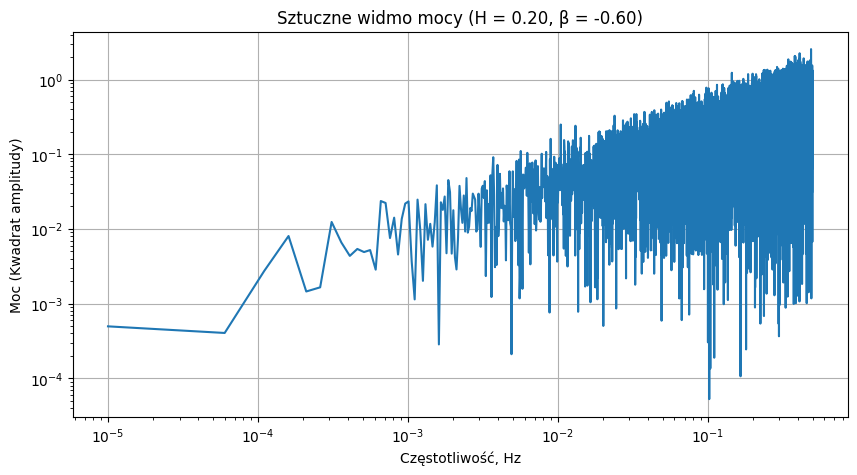

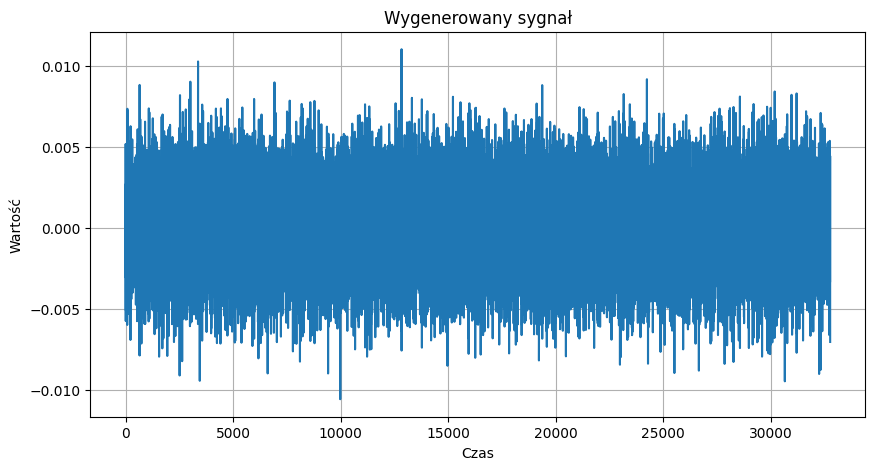

In [11]:
fake_signal_02 = generate_fake_signal(0.2)

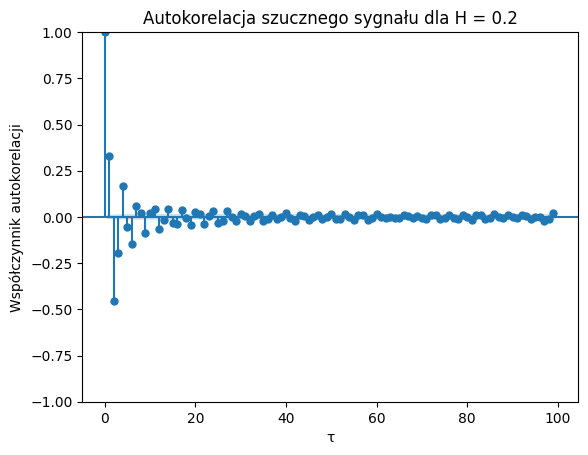

In [12]:
plot_acf(fake_signal_02, lags=np.arange(0, 100))
plt.title('Autokorelacja szucznego sygnału dla H = 0.2')
plt.ylabel('Współczynnik autokorelacji')
plt.xlabel('τ')
plt.show()

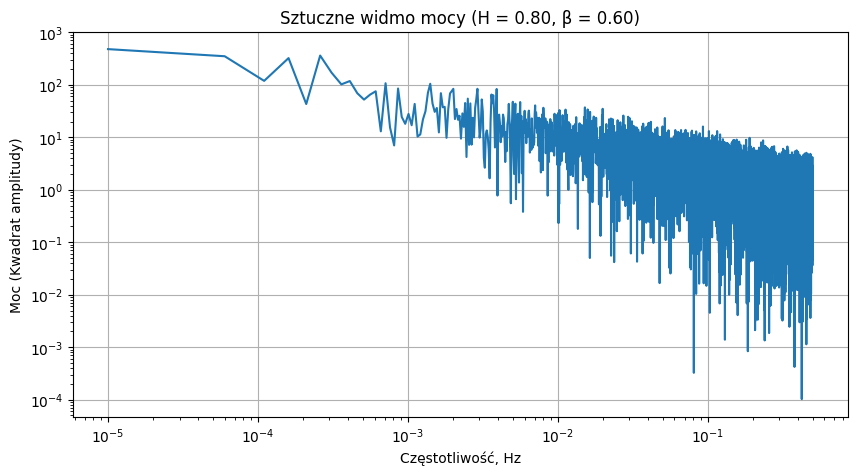

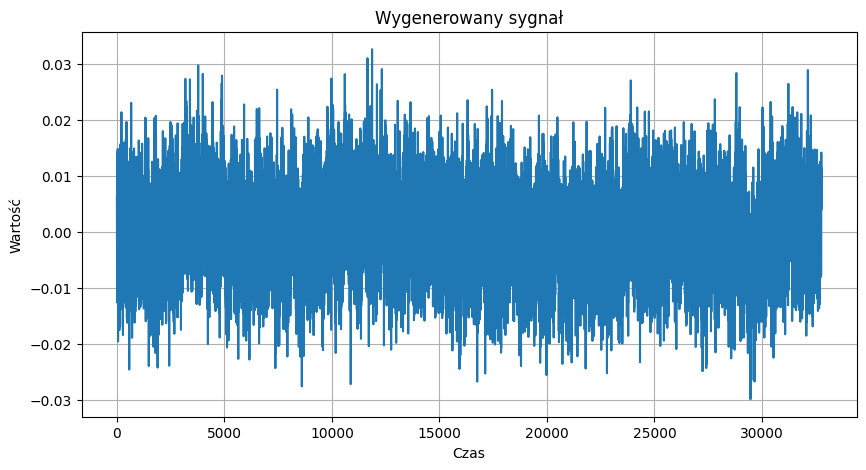

In [13]:
fake_signal_08 = generate_fake_signal(0.8)

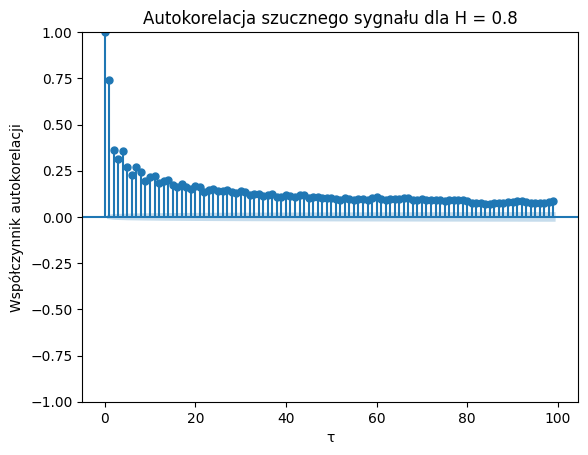

In [14]:
plot_acf(fake_signal_08, lags=np.arange(0, 100))
plt.title('Autokorelacja szucznego sygnału dla H = 0.8')
plt.ylabel('Współczynnik autokorelacji')
plt.xlabel('τ')
plt.show()

In [15]:
# funkcja estymująca wykładnik Hursta metodą RS
def estimate_hurst_rs(signal, min_window=16, max_window=None, step=2):
    N = len(signal)
    if max_window is None:
        max_window = N // 4

    window_sizes = np.arange(min_window, max_window, step)
    rs_values = []

    for win_size in window_sizes:
        n_segments = N // win_size
        rs = []

        for i in range(n_segments):
            segment = signal[i*win_size:(i+1)*win_size]
            mean = np.mean(segment)
            cum_dev = np.cumsum(segment - mean)
            R = np.max(cum_dev) - np.min(cum_dev)
            S = np.std(segment)
            if S != 0:
                rs.append(R / S)

        if len(rs) > 0:
            rs_values.append(np.mean(rs))

    log_win_sizes = np.log10(window_sizes)
    log_rs = np.log10(rs_values)

    slope, intercept = np.polyfit(log_win_sizes, log_rs, 1)
    hurst_estimate = slope

    return hurst_estimate

In [16]:
H_estimated = estimate_hurst_rs(fake_signal_02)
print(f"Estymowany współczynnik Hursta (powinno wyjść 0.2): {H_estimated:.3f}")
H_estimated = estimate_hurst_rs(fake_signal_08)
print(f"Estymowany współczynnik Hursta (powinno wyjść 0.8): {H_estimated:.3f}")

Estymowany współczynnik Hursta (powinno wyjść 0.2): 0.275
Estymowany współczynnik Hursta (powinno wyjść 0.8): 0.829
